In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pickle
import json
from IPython.display import Image, display

## NHTS Data

https://nhts.ornl.gov/

In [24]:
NHTS_PATH='../../NHTS/perpub.csv'
NHTS_TOUR_PATH='../../NHTS/tour17.csv'
NHTS_TRIP_PATH='../../NHTS/trippub.csv'

In [25]:
nhts_per=pd.read_csv(NHTS_PATH)
nhts_tour=pd.read_csv(NHTS_TOUR_PATH)
nhts_trip=pd.read_csv(NHTS_TRIP_PATH)

In [ ]:
region_cdivsmars=[31, 32]
# East North Central (IL, IN, MI, OH, WI) MSA or CMSA of 1 million or more 

## Prepare data

Predictions will be made for a synthetic population based on PUMS and ACS data. Therefore, the explanatory variables should be in the same format as the sunthetic population

In [26]:
def income_cat_nhts(row):
    if row['HHFAMINC'] >7: return "gt100"
    elif row['HHFAMINC'] >4: return "gt35-lt100"
    return "lt35"
    
def age_cat_nhts(row):
    if row['R_AGE_IMP' ]<= 19: return "19 and under"
    elif row['R_AGE_IMP' ] <= 35: return "20 to 35"
    elif row['R_AGE_IMP' ] <= 60: return "35 to 60"
    return "above 60"
    
def children_cat_nhts(row):
    if row['LIF_CYC']>2 and row['LIF_CYC']<9:
        return 'yes'
    return 'no'
    
def workers_cat_nhts(row):
    if row['WRKCOUNT'] >=2: return "two or more"
    elif row['WRKCOUNT'] == 1: return "one"
    return "none"  
  
def tenure_cat_nhts(row):
    if row['HOMEOWN'] ==1: return "owned"
    elif row['HOMEOWN'] ==2:  return "rented"
    return "other"

def sex_cat_nhts(row):
    if row['R_SEX_IMP'] == 1: return "male"
    return "female"    
    
def bach_degree_cat_nhts(row):
    if row['EDUC'] >=4: return "yes"
    return "no" 

def cars_cat_nhts(row):
    if row['HHVEHCNT'] == 0: return "none"
    elif row['HHVEHCNT'] == 1: return "one"
    return "two or more"

def race_cat_nhts(row):
    if row['R_RACE'] == 1: return "white"
    elif row['R_RACE'] == 2: return "black"
    elif row['R_RACE'] == 3: return "asian"
    return "other"

# Functions to simplify some NHTS categories
def trip_type_cat(row):
    if row['TRIPPURP']=='HBW': # includes to work and back to home trips
        return 'HBW'
    elif row['TRIPPURP']=='NHB':
        return 'NHB'
    else:
        return 'HBO'
    
def mode_cat(nhts_mode):
    # map NHTS modes to a simpler list of modes
    if nhts_mode in [3,4,5,6,8,9,17,18]:
        return 0 # drive
    elif nhts_mode ==2:
        return 1 # cycle
    elif nhts_mode ==1:
        return 2 # walk
    elif nhts_mode in [10,11,12,13,14,15,16, 19,20]:
        return 3 # PT
    else:
        return -99

In [27]:
# add unique ids and merge some variables across the 3 tables
nhts_trip['uniquePersonId']=nhts_trip.apply(lambda row: str(row['HOUSEID'])+'_'+str(row['PERSONID']), axis=1)
nhts_per['uniquePersonId']=nhts_per.apply(lambda row: str(row['HOUSEID'])+'_'+str(row['PERSONID']), axis=1)
nhts_tour['uniquePersonId']=nhts_tour.apply(lambda row: str(row['HOUSEID'])+'_'+str(row['PERSONID']), axis=1)

# Some lookups
nhts_tour=nhts_tour.merge(nhts_per[['HOUSEID', 'HH_CBSA']], on='HOUSEID', how='left')
nhts_trip=nhts_trip.merge(nhts_per[['uniquePersonId', 'R_RACE']], on='uniquePersonId', how='left')


tables={'trips': nhts_trip, 'persons': nhts_per, 'tours': nhts_tour}
# put tables in a dict so we can use a loop to avoid repetition
for t in ['trips', 'persons']:
# remove some records
    tables[t]=tables[t].loc[((tables[t]['CDIVMSAR'].isin(region_cdivsmars))&
                             (tables[t]['URBAN']==1))]
    tables[t]=tables[t].loc[tables[t]['R_AGE_IMP']>15]
    tables[t]['income']=tables[t].apply(lambda row: income_cat_nhts(row), axis=1)
    tables[t]['age']=tables[t].apply(lambda row: age_cat_nhts(row), axis=1)
    tables[t]['children']=tables[t].apply(lambda row: children_cat_nhts(row), axis=1)
    tables[t]['workers']=tables[t].apply(lambda row: workers_cat_nhts(row), axis=1)
    tables[t]['tenure']=tables[t].apply(lambda row: tenure_cat_nhts(row), axis=1)
    tables[t]['sex']=tables[t].apply(lambda row: sex_cat_nhts(row), axis=1)
    tables[t]['bach_degree']=tables[t].apply(lambda row: bach_degree_cat_nhts(row), axis=1)
    tables[t]['cars']=tables[t].apply(lambda row: cars_cat_nhts(row), axis=1)
    tables[t]['race']=tables[t].apply(lambda row: race_cat_nhts(row), axis=1)
    tables[t]=tables[t].rename(columns= {'HTPPOPDN': 'pop_per_sqmile_home'})

### Estimate average speeds by each mode in each CBSA

In [28]:
speeds={area:{} for area in set(tables['persons']['HH_CBSA'])}
tables['tours']['main_mode']=tables['tours'].apply(lambda row: mode_cat(row['MODE_D']), axis=1)

for area in speeds:
    this_cbsa=tables['tours'][tables['tours']['HH_CBSA']==area]
    for m in [0,1,2, 3]:
        all_speeds=this_cbsa.loc[((this_cbsa['main_mode']==m) & 
                                  (this_cbsa['TIME_M']>0))].apply(
                                    lambda row: row['DIST_M']/row['TIME_M'], axis=1)
        if len(all_speeds)>0:
            speeds[area]['km_per_minute_'+str(m)]=1.62* all_speeds.mean()
        else:
            speeds[area]['km_per_minute_'+str(m)]=float('nan')
    speeds[area]['walk_km_'+str(m)]=1.62*this_cbsa.loc[this_cbsa['main_mode']==3,'PMT_WALK'].mean()
    speeds[area]['drive_km_'+str(m)]=1.62*this_cbsa.loc[this_cbsa['main_mode']==3,'PMT_POV'].mean()

# for any region where a mode is not observed at all, 
# assume the speed of that mode is
# that of the slowest region
for area in speeds:
    for mode_speed in speeds[area]:
        if not float(speeds[area][mode_speed]) == float(speeds[area][mode_speed]):
            print('Using lowest speed')
            speeds[area][mode_speed] = np.nanmin([speeds[other_area][mode_speed] for other_area in speeds])

Using lowest speed


## Create the mode choice dataset

In [29]:
tables['trips']['network_dist_km']=tables['trips'].apply(lambda row: row['TRPMILES']/1.62, axis=1)
tables['trips']['mode']=tables['trips'].apply(lambda row: mode_cat(row['TRPTRANS']), axis=1) 
tables['trips']['purpose']=tables['trips'].apply(lambda row: trip_type_cat(row), axis=1)
tables['trips']=tables['trips'].loc[tables['trips']['mode']>=0]
tables['trips'].loc[tables['trips']['TRPMILES']<0, 'TRPMILES']=0 # -9 for work-from-home

# create the mode choice table
mode_table=pd.DataFrame()
#    add the trip stats for each potential mode
mode_table['drive_time_minutes']=tables['trips'].apply(lambda row: row['network_dist_km']/speeds[row['HH_CBSA']]['km_per_minute_'+str(0)], axis=1)
mode_table['cycle_time_minutes']=tables['trips'].apply(lambda row: row['network_dist_km']/speeds[row['HH_CBSA']]['km_per_minute_'+str(1)], axis=1)
mode_table['walk_time_minutes']=tables['trips'].apply(lambda row: row['network_dist_km']/speeds[row['HH_CBSA']]['km_per_minute_'+str(2)], axis=1)
mode_table['PT_time_minutes']=tables['trips'].apply(lambda row: row['network_dist_km']/speeds[row['HH_CBSA']]['km_per_minute_'+str(3)], axis=1)
mode_table['walk_time_PT_minutes']=tables['trips'].apply(lambda row: speeds[row['HH_CBSA']]['walk_km_'+str(3)]/speeds[row['HH_CBSA']]['km_per_minute_'+str(2)], axis=1)
mode_table['drive_time_PT_minutes']=tables['trips'].apply(lambda row: speeds[row['HH_CBSA']]['drive_km_'+str(3)]/speeds[row['HH_CBSA']]['km_per_minute_'+str(0)], axis=1)

for col in ['income', 'age', 'children', 'workers', 'tenure', 'sex', 
            'bach_degree', 'purpose', 'cars', 'race']:
    new_dummys=pd.get_dummies(tables['trips'][col], prefix=col)
    mode_table=pd.concat([mode_table, new_dummys],  axis=1)

for col in [ 'pop_per_sqmile_home', 'network_dist_km', 'mode']:
    mode_table[col]=tables['trips'][col]

## Data Summary

In [43]:
mode_table.describe()

,drive_time_minutes,cycle_time_minutes,walk_time_minutes,PT_time_minutes,walk_time_PT_minutes,drive_time_PT_minutes,income_gt100,income_gt35-lt100,income_lt35,age_19 and under,...,cars_none,cars_one,cars_two or more,race_asian,race_black,race_other,race_white,pop_per_sqmile_home,network_dist_km,mode
count,30460.000000,30460.000000,30460.000000,30460.000000,30460.000000,30460.000000,30460.000000,30460.000000,30460.000000,30460.000000,...,30460.000000,30460.000000,30460.000000,30460.000000,30460.000000,30460.000000,30460.000000,30460.000000,30460.000000,30460.000000
mean,9.476498,37.434778,50.765869,9.129052,0.354470,1.342156,0.342351,0.436638,0.221011,0.034701,...,0.028693,0.268713,0.702594,0.026133,0.066415,0.034865,0.872587,5135.175640,5.923780,0.274228
std,55.751965,224.958127,289.566511,51.188960,0.189492,0.696774,0.474504,0.495977,0.414935,0.183025,...,0.166946,0.443298,0.457124,0.159532,0.249010,0.183442,0.333441,5603.814438,34.163899,0.735796
min,-8.730203,-29.272667,-41.789841,-8.564834,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,-5.555556,0.000000
25%,1.334537,4.904798,6.868826,1.213552,0.301044,1.053405,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1500.000000,0.839506,0.000000
50%,3.259999,12.288015,17.266130,3.061452,0.301044,1.053405,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3000.000000,2.050000,0.000000
75%,7.931147,30.043390,41.796645,7.672411,0.511179,1.499395,1.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,7000.000000,4.988889,0.000000
max,3834.909607,12858.581750,18356.990887,3762.267984,0.675261,3.401789,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30000.000000,2440.384568,3.000000


## Fit a random forest classifier

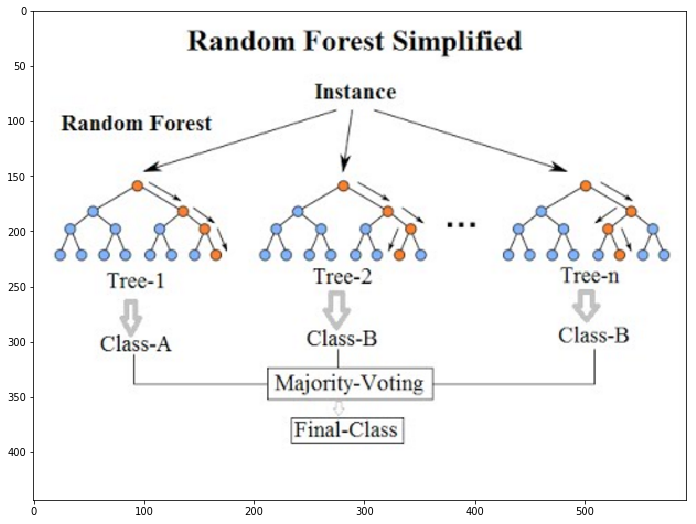

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('./rf.png')
plt.figure(figsize=[16,9])
imgplot = plt.imshow(img)
plt.show()

In [31]:
features=[c for c in mode_table.columns if not c=='mode']

X=mode_table[features]
y=mode_table['mode']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

rf = RandomForestClassifier(n_estimators =32, random_state=0, class_weight='balanced')
# Test different values of the hyper-parameters:
# 'max_features','max_depth','min_samples_split' and 'min_samples_leaf'

# Create the parameter ranges
maxDepth = list(range(5,100,5)) # Maximum depth of tree
maxDepth.append(None)
minSamplesSplit = range(2,42,5) # Minimum samples required to split a node
minSamplesLeaf = range(1,101,10) # Minimum samples required at each leaf node

#Create the grid
randomGrid = {
               'max_depth': maxDepth,
               'min_samples_split': minSamplesSplit,
               'min_samples_leaf': minSamplesLeaf}

# Create the random search object
rfRandom = RandomizedSearchCV(estimator = rf, param_distributions = randomGrid,
                               n_iter = 512, cv = 5, verbose=1, random_state=0, 
                               refit=True, scoring='f1_macro', n_jobs=-1)
# f1-macro better where there are class imbalances as it 
# computes f1 for each class and then takes an unweighted mean
# "In problems where infrequent classes are nonetheless important, 
# macro-averaging may be a means of highlighting their performance."

# Perform the random search and find the best parameter set
rfRandom.fit(X_train, y_train)
rfWinner=rfRandom.best_estimator_
bestParams=rfRandom.best_params_

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed: 20.0min finished


## Feature importances

Feature ranking:
1. network_dist_km (0.142878)
2. drive_time_minutes (0.117654)
3. cycle_time_minutes (0.104725)
4. walk_time_minutes (0.103487)
5. PT_time_minutes (0.102736)
6. pop_per_sqmile_home (0.047824)
7. cars_none (0.032231)
8. walk_time_PT_minutes (0.023911)
9. drive_time_PT_minutes (0.020548)
10. cars_two or more (0.015049)
11. race_white (0.014343)
12. cars_one (0.014266)
13. purpose_HBO (0.013880)
14. age_above 60 (0.013049)
15. workers_two or more (0.012575)
16. children_no (0.012509)
17. income_gt35-lt100 (0.012412)
18. workers_one (0.012376)
19. tenure_owned (0.012246)
20. purpose_NHB (0.012033)
21. workers_none (0.011926)
22. bach_degree_yes (0.011818)
23. sex_male (0.011787)
24. age_35 to 60 (0.011760)
25. tenure_rented (0.011307)
26. race_black (0.010974)
27. bach_degree_no (0.010970)
28. sex_female (0.010713)
29. income_lt35 (0.010518)
30. age_20 to 35 (0.010408)
31. income_gt100 (0.010159)
32. children_yes (0.010055)
33. purpose_HBW (0.009701)
34. age_19 and under (

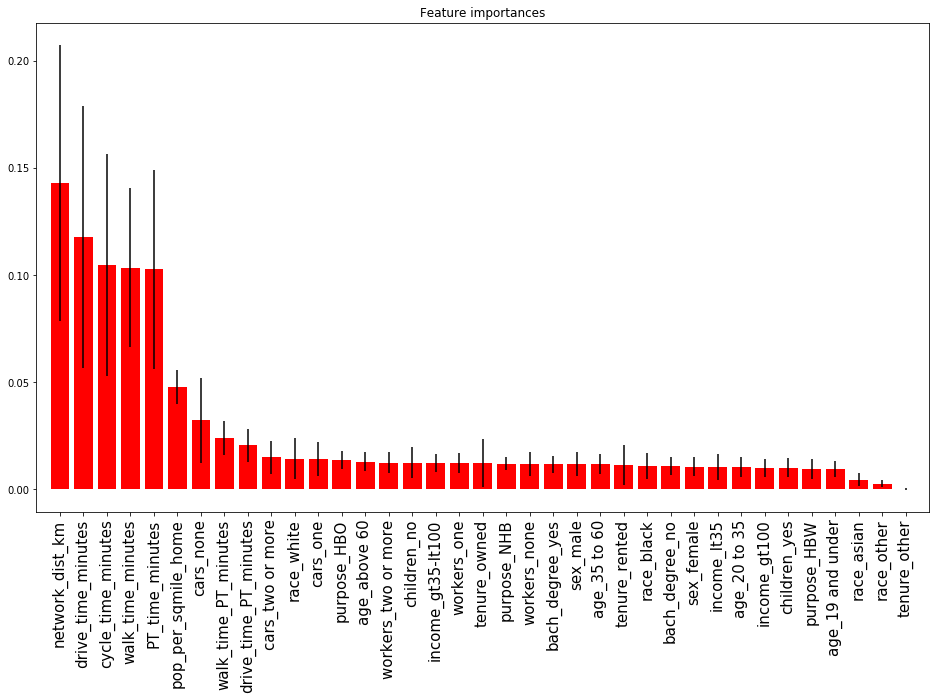

In [36]:
importances = rfWinner.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfWinner.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(len(features)):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16, 9))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90, fontsize=15)
plt.xlim([-1, len(features)])
plt.show()

## Check the accuracy

In [42]:
predicted=rfWinner.predict(X_test)
conf_mat=confusion_matrix(y_test, predicted)
print('Confusion Matrix \n')
print('Drive  Cycle  Walk  PT \n')
print(conf_mat)
# rows are true labels and coluns are predicted labels
# Cij  is equal to the number of observations 
# known to be in group i but predicted to be in group j.
for i in range(len(conf_mat)):
    print('\nTotal True for Class '+str(i)+': '+str(sum(conf_mat[i])))
    print('Total Predicted for Class '+str(i)+': '+str(sum([p[i] for p in conf_mat])))

Confusion Matrix 

Drive  Cycle  Walk  PT 

[[5105    0  152   25]
 [  19   27    1    3]
 [ 105    0  497    8]
 [  48    0    6   96]]

Total True for Class 0: 5282
Total Predicted for Class 0: 5277

Total True for Class 1: 50
Total Predicted for Class 1: 27

Total True for Class 2: 610
Total Predicted for Class 2: 656

Total True for Class 3: 150
Total Predicted for Class 3: 132


## Try Gradient Boosted Tree Classifier

In [55]:
gbdt = GradientBoostingClassifier(n_estimators =64, random_state=0)
maxDepth = list(range(20,60,10)) # Maximum depth of tree
maxDepth.append(None)
minSamplesSplit = range(20, 60, 10) # Minimum samples required to split a node
minSamplesLeaf = range(20,60,10) # Minimum samples required at each leaf node

#Create the grid
randomGrid = {'max_depth': maxDepth,
               'min_samples_split': minSamplesSplit,
               'min_samples_leaf': minSamplesLeaf}

# Create the random search object
gbdtRandom = RandomizedSearchCV(estimator = gbdt, param_distributions = randomGrid,
                               n_iter = 10, cv = 5, verbose=1, random_state=0, 
                               refit=True, scoring='f1_macro', n_jobs=-1)
gbdtRandom.fit(X_train, y_train)
gbdtWinner=gbdtRandom.best_estimator_
bestParams=gbdtRandom.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 45.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 53.4min finished


In [56]:
predicted=gbdtWinner.predict(X_test)
conf_mat=confusion_matrix(y_test, predicted)
print('Confusion Matrix \n')
print('Drive  Cycle  Walk  PT \n')
print(conf_mat)
# rows are true labels and coluns are predicted labels
# Cij  is equal to the number of observations 
# known to be in group i but predicted to be in group j.
for i in range(len(conf_mat)):
    print('\nTotal True for Class '+str(i)+': '+str(sum(conf_mat[i])))
    print('Total Predicted for Class '+str(i)+': '+str(sum([p[i] for p in conf_mat])))

Confusion Matrix 

Drive  Cycle  Walk  PT 

[[5193    0   75   14]
 [  21   26    0    3]
 [ 107    0  498    5]
 [  54    0    5   91]]

Total True for Class 0: 5282
Total Predicted for Class 0: 5375

Total True for Class 1: 50
Total Predicted for Class 1: 26

Total True for Class 2: 610
Total Predicted for Class 2: 578

Total True for Class 3: 150
Total Predicted for Class 3: 113
